In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import datasets, transforms, models
#from preprocessing import resizer, resize_image_to_square
from PIL import Image, ImageOps
import os
import torch.nn as nn
import torch
import torch.optim as optim

from skimage.transform import resize


from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 




#https://www.kaggle.com/lukaanicin/book-covers-dataset?select=main_dataset.csv

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data Acquisition and Preprocessing


In [ ]:
maindf = pd.read_csv('/content/gdrive/MyDrive/machine vision project/data/main_dataset.csv')
maindf.rename(columns={'book_depository_stars':'rating'}, inplace = True)
maindf.dropna(subset = ['img_paths', 'category'])

maindf.head()

,image,name,author,format,rating,price,currency,old_price,isbn,category,img_paths
0,https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...,Fantastic Beasts and Where to Find Them,J. K. Rowling,Hardback,4.5,11.05,$,21.5,9781408708989,Art-Photography,dataset/Art-Photography/0000001.jpg
1,https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...,The Mindfulness Colouring Book,Emma Farrarons,Paperback,4.0,6.8,$,10.5,9780752265629,Art-Photography,dataset/Art-Photography/0000002.jpg
2,https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...,Fantastic Beasts: The Crimes of Grindelwald - ...,J.K. Rowling,Hardback,4.0,15.14,$,18.0,9781408711705,Art-Photography,dataset/Art-Photography/0000003.jpg
3,https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...,Moleskine Large Watercolour Album And Notebook,Moleskine,Notebook / blank book,0.0,11.86,$,19.9,9788883705625,Art-Photography,dataset/Art-Photography/0000004.jpg
4,https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...,The Complete MAUS,Art Spiegelman,Paperback,4.5,17.61,$,21.1,9780141014081,Art-Photography,dataset/Art-Photography/0000005.jpg


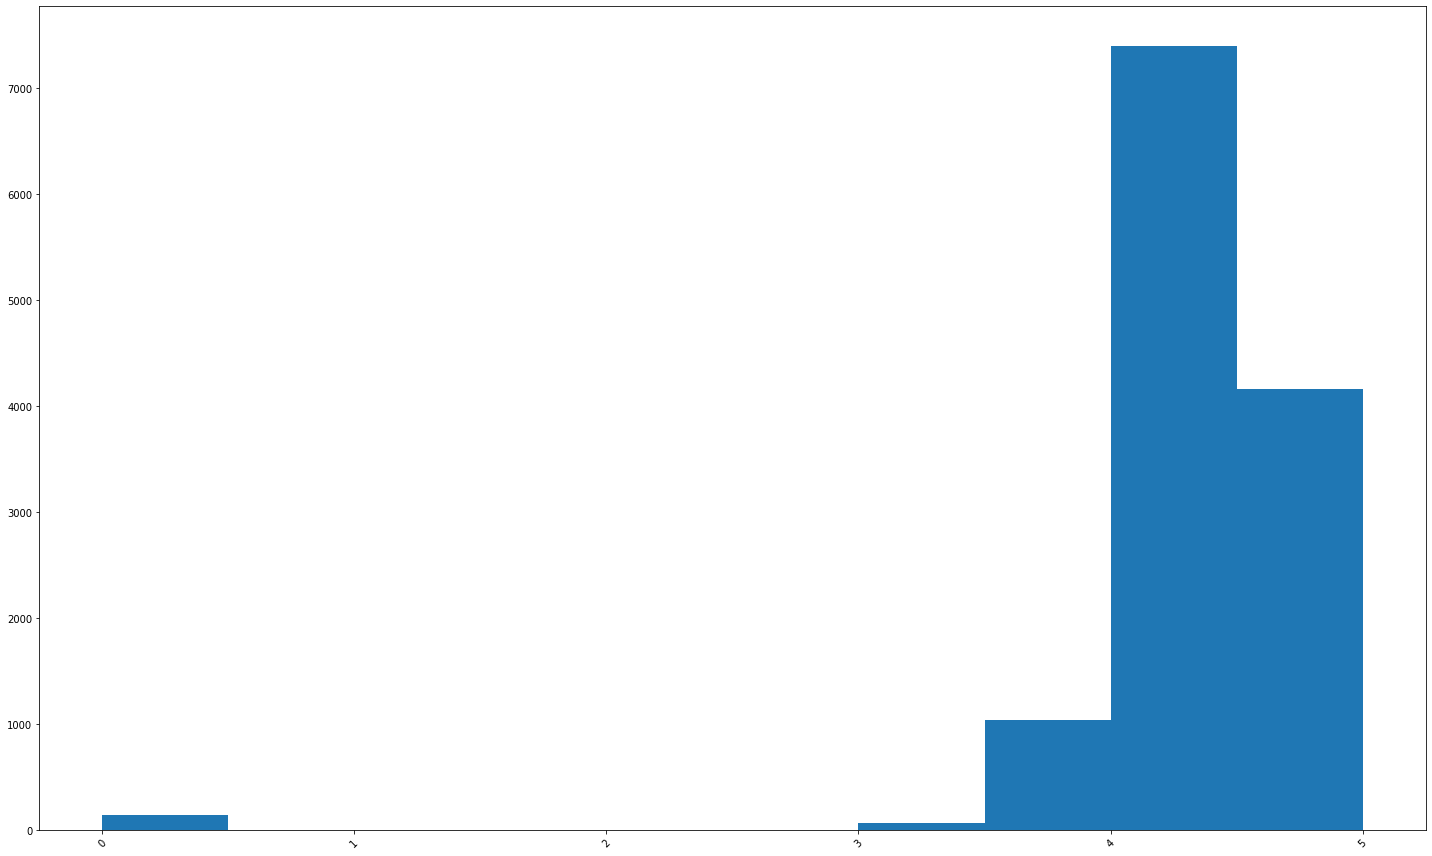

In [ ]:
plt.figure(figsize=(20,12))
plt.xticks(rotation = 45)

plt.hist(maindf['rating'])
plt.tight_layout()

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

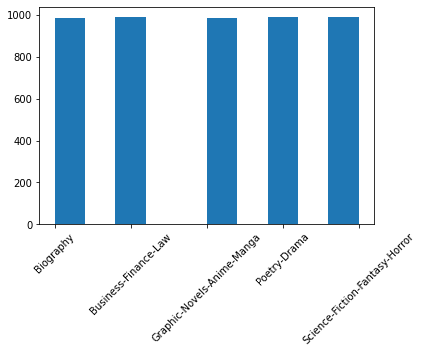

In [ ]:

genres = ['Science-Fiction-Fantasy-Horror', 'Biography', 'Graphic-Novels-Anime-Manga', 'Poetry-Drama', 'Business-Finance-Law']


genreCats = maindf[maindf['category'].isin(genres) ]
plt.hist(genreCats['category'])
plt.xticks(rotation = 45)

In [ ]:
maindf.describe()

,rating,old_price,isbn
count,12819.000000,11003.000000,1.281900e+04
mean,4.075903,15.418995,9.780991e+12
std,0.539633,10.410598,9.081666e+08
min,0.000000,3.100000,9.780002e+12
25%,4.000000,10.300000,9.780341e+12
50%,4.000000,12.900000,9.780785e+12
75%,4.500000,17.000000,9.781477e+12
max,5.000000,222.600000,9.789888e+12


In [ ]:
maindf['category'].value_counts()

Poetry-Drama                      990
Teen-Young-Adult                  990
Humour                            989
Business-Finance-Law              989
Science-Fiction-Fantasy-Horror    989
Biography                         988
Crime-Thriller                    988
Graphic-Novels-Anime-Manga        988
Personal-Development              987
Childrens-Books                   986
Art-Photography                   982
Romance                           978
Entertainment                     975
Name: category, dtype: int64

In [ ]:
maindf['rating'].value_counts()

4.0    7404
4.5    4024
3.5    1040
0.0     144
5.0     136
3.0      65
1.0       3
2.5       2
2.0       1
Name: rating, dtype: int64

In [ ]:
'''
imgFolder = '/content/gdrive/MyDrive/machine vision project/data/ratings dataset/3.0'

for image_file_name in os.listdir(imgFolder):
    if image_file_name.endswith(".jpg"):
        try:
            im = Image.open(imgFolder+image_file_name)
           
            im = im.resize((128,128))
            im = ImageOps.grayscale(im)
            os.remove(imgFolder+image_file_name)
            im.save(imgFolder+image_file_name)
            
            
        except Exception:
            pass
'''

'\nimgFolder = \'/content/gdrive/MyDrive/machine vision project/data/ratings dataset/3.0\'\n\nfor image_file_name in os.listdir(imgFolder):\n    if image_file_name.endswith(".jpg"):\n        try:\n            im = Image.open(imgFolder+image_file_name)\n           \n            im = im.resize((128,128))\n            im = ImageOps.grayscale(im)\n            os.remove(imgFolder+image_file_name)\n            im.save(imgFolder+image_file_name)\n            \n            \n        except Exception:\n            pass\n'

In [ ]:
'''img = cv2.imread('/content/gdrive/MyDrive/machine vision project/data/ratings dataset/3.0/0000001.jpg')
plt.imshow(img)
plt.show()'''

"img = cv2.imread('/content/gdrive/MyDrive/machine vision project/data/ratings dataset/3.0/0000001.jpg')\nplt.imshow(img)\nplt.show()"

In [ ]:
transforms = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Resize(128),
                    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])

In [ ]:
book_covers_dir = '/content/gdrive/MyDrive/machine vision project/data/ratings dataset'

fulldata = datasets.ImageFolder(root = book_covers_dir, transform=transforms )
fulldata = torch.utils.data.Subset(fulldata, np.random.choice(len(fulldata), 2000, replace=False))

train_size = int(0.8 * (len(fulldata)-3000))
validation_size = len(fulldata) - train_size
train_set, val_set = torch.utils.data.random_split(fulldata, [train_size, validation_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

In [ ]:
model = models.densenet161(pretrained=True)
# Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Create new classifier for model using torch.nn as nn library
classifier_input = model.classifier.in_features
num_labels = 10 #PUT IN THE NUMBER OF LABELS IN YOUR DATA
classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           nn.LogSoftmax(dim=1))
# Replace default classifier with new classifier
model.classifier = classifier

In [ ]:
# Find the device available to use using torch library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the device specified above
model.to(device)

In [ ]:
# Set the error function using torch.nn as nn library
criterion = nn.NLLLoss()
# Set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.classifier.parameters())

In [ ]:
epochs = 10
lr = 0.1
accs = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training
        counter += 1
        print(counter, "/", len(train_loader))
        
    # Evaluating the model
    model.eval()
    counter = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the progress of our evaluation
            counter += 1
            print(counter, "/", len(val_loader))
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    # Print out the information
    accs.append(accuracy/len(val_loader))
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

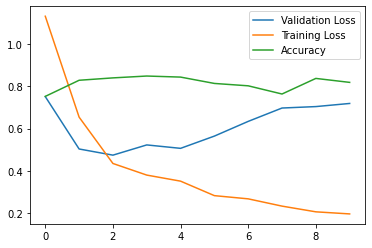

In [ ]:
plt.plot(range(0,10), val_losses,  label = "Validation Loss")
plt.plot(range(0,10), train_losses, label = "Training Loss")
plt.plot(range(0,10), accs, label = ("Accuracy"))

plt.legend()

In [ ]:
np.average(accs)

0.8150000000000001